In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import pickle

# Scikit-Learn
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn import svm

# XGBoost
import xgboost as xgb

# Torch
import torch
from torch.utils.data import DataLoader

# From src
from src.inference import calculate_metrics

In [14]:
seed = 65
np.random.seed(seed)
rng = np.random.RandomState(seed)

In [31]:
# Horizon (24 hours)
H = 24
TARGET_COLS = [f'load_t+{h}' for h in range(1, H + 1)]
TEST_INDEX = pd.date_range("2021-09-11 14:00:00", "2022-05-14 23:00:00", freq='h')

In [25]:
# Convert TensorDatasets back to numpy for the ML algorithms
train = torch.load("../data/train.pt")
train_loader = DataLoader(train, batch_size=len(train))
X_train = next(iter(train_loader))[0].numpy()
y_train = next(iter(train_loader))[1].numpy()

val = torch.load("../data/val.pt")
val_loader = DataLoader(val, batch_size=len(val))
X_val = next(iter(val_loader))[0].numpy()
y_val = next(iter(val_loader))[1].numpy()

test = torch.load("../data/test.pt")
test_loader = DataLoader(test, batch_size=len(test))
X_test = next(iter(test_loader))[0].numpy()
y_test = next(iter(test_loader))[1].numpy()

In [29]:
scaler = pickle.load(open('../data/scaler.pkl', 'rb'))

# Random Forests
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor

In [26]:
# parameters
max_depth = 6
n_estimators = 30

## Without MultiOutputRegressor Functionality

In [48]:
rf_reg = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=rng)
rf_reg.fit(X_train, y_train)
y_pred = rf_reg.predict(X_test)

In [49]:
predictions = scaler.inverse_transform(y_pred)
labels = scaler.inverse_transform(y_test)

In [50]:
df_pred = pd.DataFrame(predictions, columns=TARGET_COLS, index=TEST_INDEX)
df_true = pd.DataFrame(labels, columns=TARGET_COLS, index=TEST_INDEX)

In [51]:
rf_metrics = calculate_metrics(df_true, df_pred)

Mean Absolute Error: 8.802934043218443
Mean Absolute % Error: 9.797556075641364
Symmetric Mean Absolute % Error: 9.797556075641364
Root Mean Squared Error: 11.696342374167457
R^2 Score: 0.8596156693732047


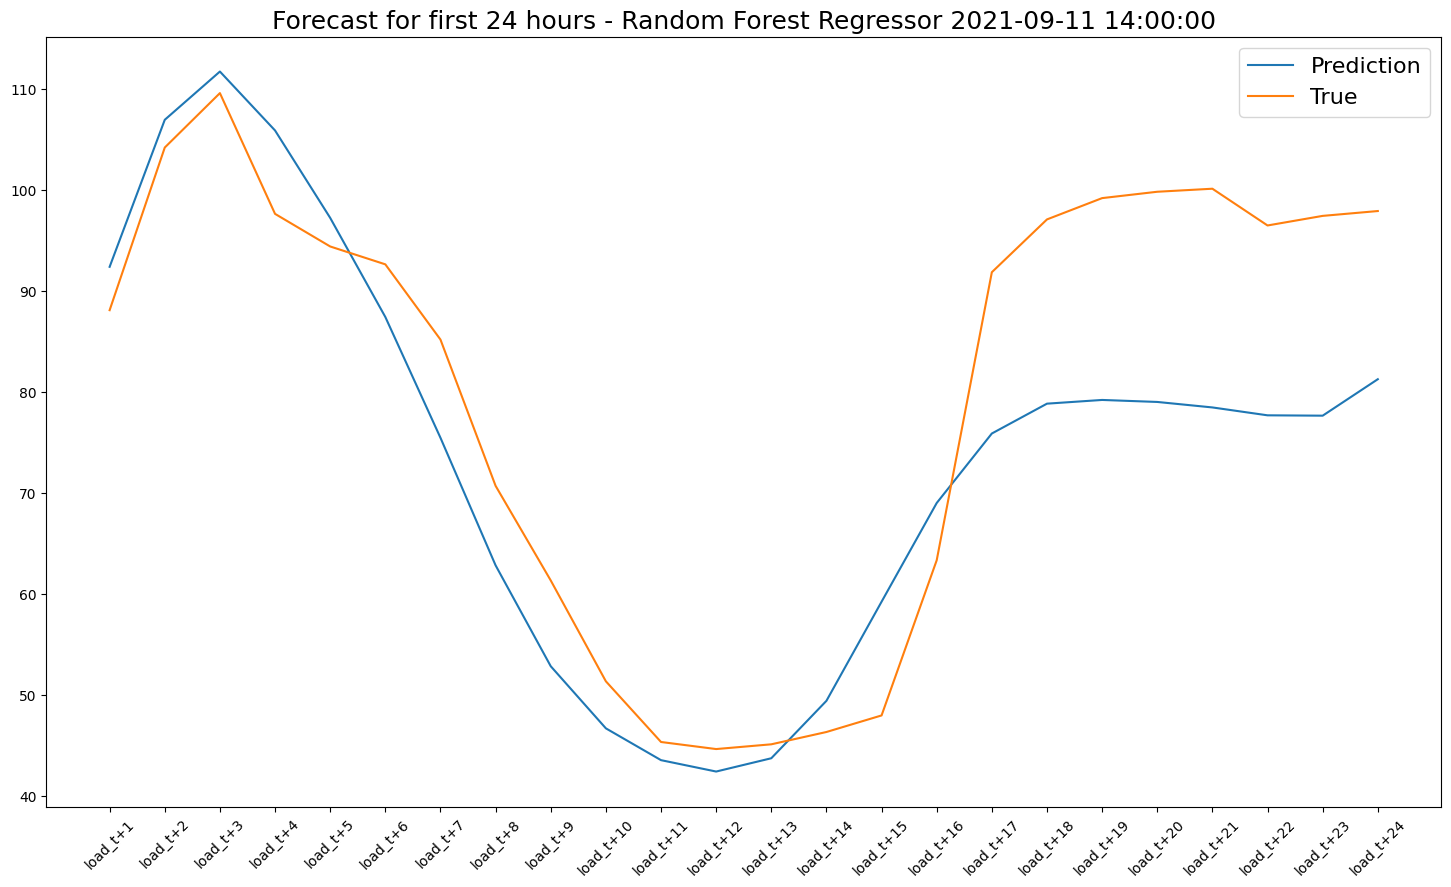

In [52]:
plt.figure(figsize=(18,10))
plt.plot(df_pred.iloc[0], label='Prediction')
plt.plot(df_true.iloc[0], label='True')
plt.legend(fontsize=16)
plt.xticks(rotation=45)
plt.title(f'Forecast for first 24 hours - Random Forest Regressor {df_true.index[0]}', fontsize=18)
plt.show()

## With MultiOutputRegressor estimators

In [53]:
multirf_reg = MultiOutputRegressor(
    RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=rng)
)

multirf_reg.fit(X_train, y_train)
y_pred = multirf_reg.predict(X_test)

In [54]:
predictions = scaler.inverse_transform(y_pred)
labels = scaler.inverse_transform(y_test)

In [55]:
df_pred = pd.DataFrame(predictions, columns=TARGET_COLS, index=TEST_INDEX)
df_true = pd.DataFrame(labels, columns=TARGET_COLS, index=TEST_INDEX)

In [56]:
multirf_metrics = calculate_metrics(df_true, df_pred)

Mean Absolute Error: 6.98399318648956
Mean Absolute % Error: 8.078626266475267
Symmetric Mean Absolute % Error: 8.078626266475267
Root Mean Squared Error: 9.656973008073267
R^2 Score: 0.9043000633161765


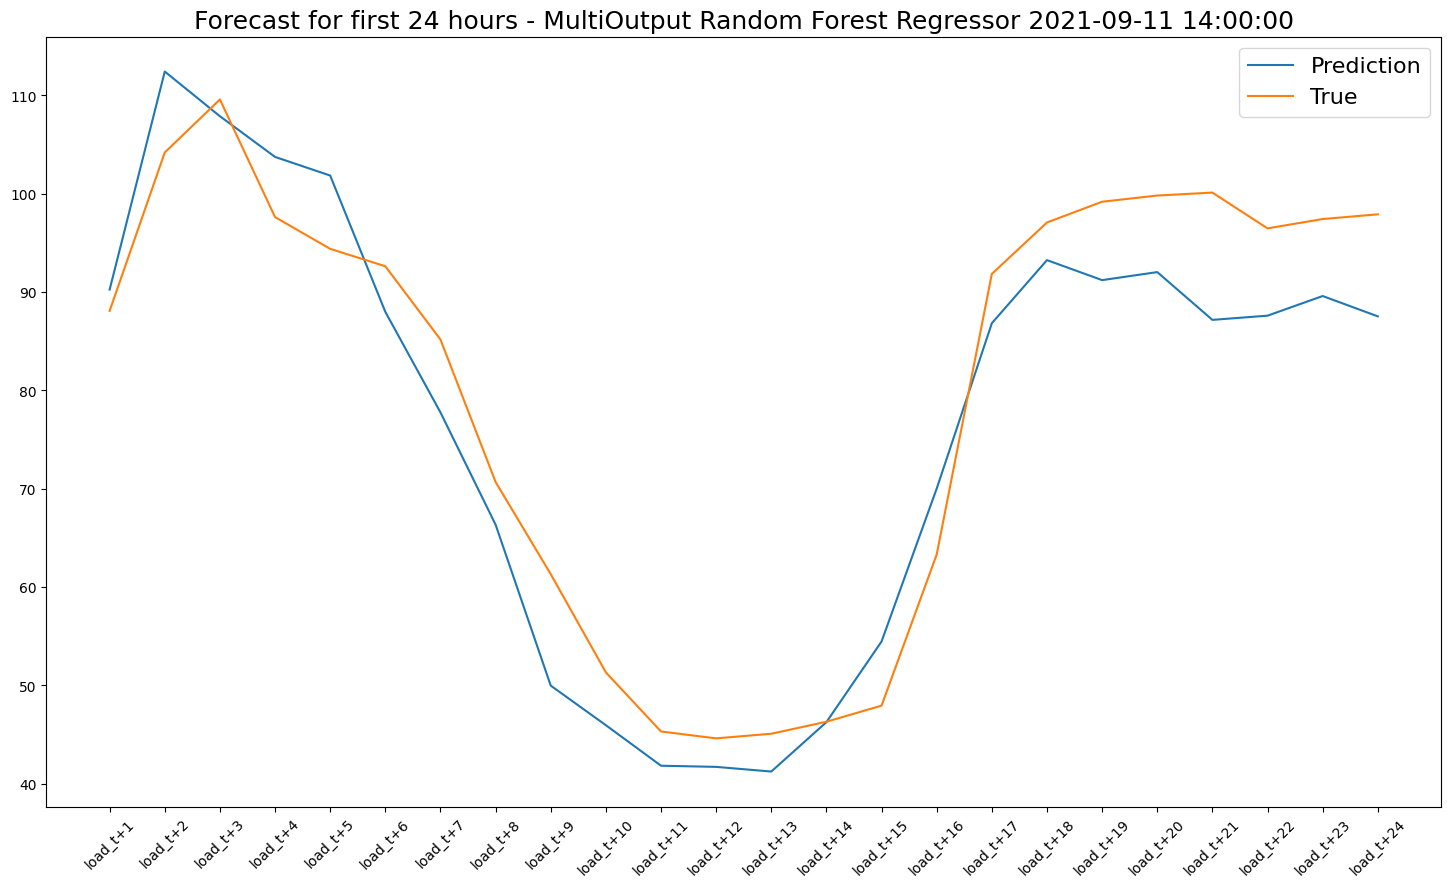

In [57]:
plt.figure(figsize=(18,10))
plt.plot(df_pred.iloc[0], label='Prediction')
plt.plot(df_true.iloc[0], label='True')
plt.legend(fontsize=16)
plt.xticks(rotation=45)
plt.title(f'Forecast for first 24 hours - MultiOutput Random Forest Regressor {df_true.index[0]}', fontsize=18)
plt.show()

# Support Vector Machines (Regression)
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR

In [58]:
svm_kernel = 'rbf'
epsilon = 0.1
reg_C = 1 

svm_reg = MultiOutputRegressor(svm.SVR(kernel=svm_kernel, C=reg_C, epsilon=epsilon))

In [59]:
svm_reg.fit(X_train, y_train)

MultiOutputRegressor(estimator=SVR(C=1))

In [60]:
y_pred = svm_reg.predict(X_test)

In [61]:
predictions = scaler.inverse_transform(y_pred)
labels = scaler.inverse_transform(y_test)

In [62]:
df_pred = pd.DataFrame(predictions, columns=TARGET_COLS, index=TEST_INDEX)
df_true = pd.DataFrame(labels, columns=TARGET_COLS, index=TEST_INDEX)

In [63]:
svm_metrics = calculate_metrics(df_true, df_pred)


Mean Absolute Error: 6.1554758194224375
Mean Absolute % Error: 7.153263342597831
Symmetric Mean Absolute % Error: 7.153263342597831
Root Mean Squared Error: 8.336185330226952
R^2 Score: 0.9286880354641619


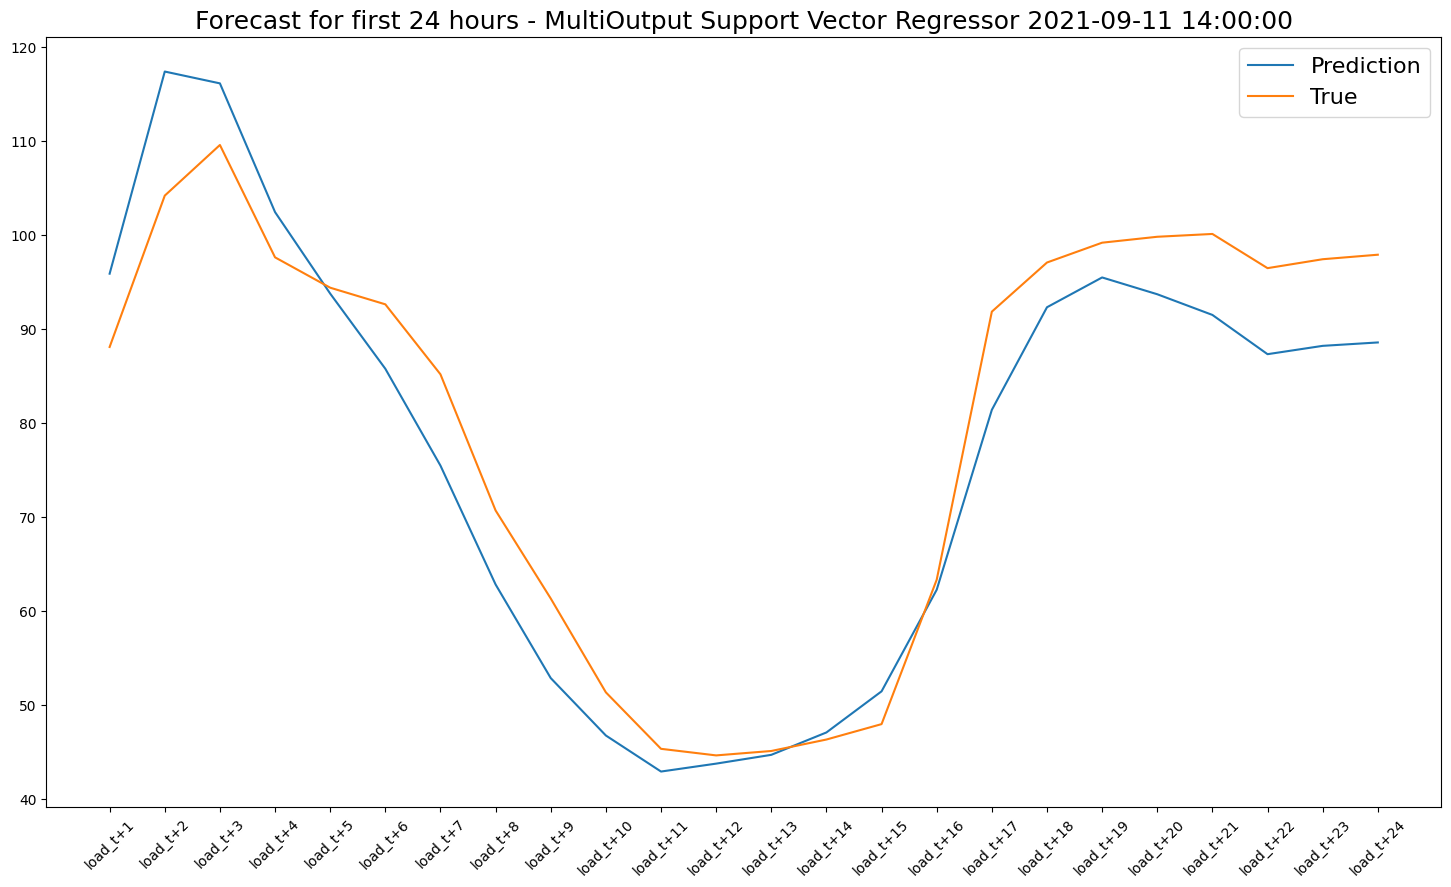

In [64]:
plt.figure(figsize=(18,10))
plt.plot(df_pred.iloc[0], label='Prediction')
plt.plot(df_true.iloc[0], label='True')
plt.legend(fontsize=16)
plt.xticks(rotation=45)
plt.title(f'Forecast for first 24 hours - MultiOutput Support Vector Regressor {df_true.index[0]}', fontsize=18)
plt.show()

In [39]:
# Save
#from sklearn.external import joblib
#joblib.dump(svm_reg, 'svm_regressor.pkl')

# XGBoost (Gradient Boosted Trees)

In [65]:
xgb_reg = xgb.XGBRegressor(
    n_estimators=n_estimators,
    max_depth=max_depth,
    objective='reg:squarederror',
    tree_method='hist',
)


multi_xgb = MultiOutputRegressor(xgb_reg).fit(X_train, y_train)

In [66]:
y_pred = multi_xgb.predict(X_test)

In [67]:
predictions = scaler.inverse_transform(y_pred)
labels = scaler.inverse_transform(y_test)

In [68]:
df_pred = pd.DataFrame(predictions, columns=TARGET_COLS, index=TEST_INDEX)
df_true = pd.DataFrame(labels, columns=TARGET_COLS, index=TEST_INDEX)

In [69]:
xgb_metrics = calculate_metrics(df_true, df_pred)

Mean Absolute Error: 6.482516
Mean Absolute % Error: 7.524579763412476
Symmetric Mean Absolute % Error: 7.524579763412476
Root Mean Squared Error: 8.84615096535524
R^2 Score: 0.9196954460517347


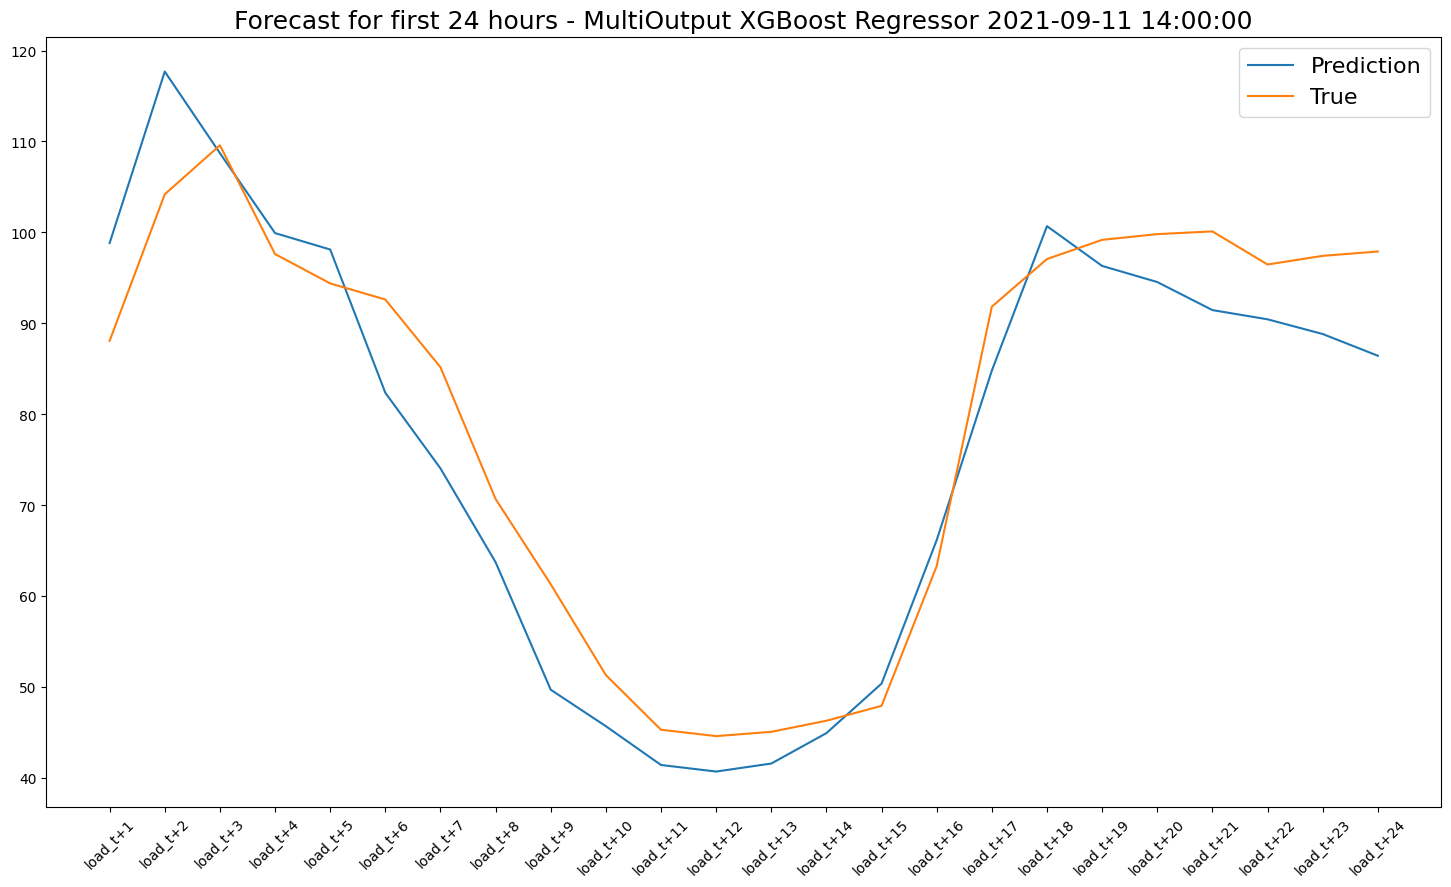

In [70]:
plt.figure(figsize=(18,10))
plt.plot(df_pred.iloc[0], label='Prediction')
plt.plot(df_true.iloc[0], label='True')
plt.legend(fontsize=16)
plt.xticks(rotation=45)
plt.title(f'Forecast for first 24 hours - MultiOutput XGBoost Regressor {df_true.index[0]}', fontsize=18)
plt.show()